<a href="https://colab.research.google.com/github/RajArPatra/MIDAS-task-2/blob/main/MIDAS_Task2_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Download

In [ ]:
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
!unzip trainPart1.zip


--2021-04-09 15:25:16--  https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pan6mutc5xj5kj0/trainPart1.zip [following]
--2021-04-09 15:25:16--  https://www.dropbox.com/s/raw/pan6mutc5xj5kj0/trainPart1.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc360644174b96b0f4f1e20db329.dl.dropboxusercontent.com/cd/0/inline/BMQdHh29VO3TgEVBRmQSeSZ7IQw_vhATyj_Kz3q3Qa7YTrW_A5m3gdlhCWVnWbVhb9se8MaAtWlAjKaCQubKpKRQnj2qGZ4_bocRhBQYnDIq1PeyOZywEFp6-y43zn0q1GhQLbgJLN5BcQhKIE8HX4_S/file# [following]
--2021-04-09 15:25:16--  https://uc360644174b96b0f4f1e20db329.dl.dropboxusercontent.com/cd/0/inline/BMQdHh29VO3TgEVBRmQSeSZ7IQw_vhATyj_Kz3q3Qa7YTrW_A5m3gdlhCWVnWbVhb9se8MaAtWlAjKaCQ

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
import torchvision
import os
import numpy as np
from skimage import io,transform as ts
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from torch.autograd import Variable
import distutils
from distutils import dir_util
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

GPU selection

In [ ]:
if torch.cuda.is_available():
  device='cuda'
else :
   device='cpu'
device

'cuda'

Data Augmentation to increase size and hence increasing training data

In [ ]:
from albumentations.pytorch import ToTensor
import albumentations as A

seq = A.Compose(
    [   A.Resize(28,28),
      
     
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.3),
            A.Blur(blur_limit=3, p=0.3),
        ], p=0.3),
        
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.3),
        ], p=0.3),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 1
        ),
        
        A.Normalize(
            mean=[0.9430, 0.9430, 0.9430], 

            std=[0.4004, 0.4004, 0.4004]),
        
        ToTensor() # convert the image to PyTorch tensor
    ],
    p = 1
)
    
    
seq_test=A.Compose(
    [   A.Resize(28,28),ToTensor() ])

# DATASET AND DATALOADER

In [ ]:
import imageio
import glob

class Custom_dataset(Dataset):
    def __init__(self,root='/content/merged_data',img_type='png',mnist=False,transforms=None):
      org_lst=os.listdir(root)
      cnt=0
      self.map={}
      self.root=root
      self.transforms=transforms
      self.lst=[]
      self.flag=False
      if root[-1]=='n':
           
        if mnist!=True:
          
          self.lst=glob.glob(root+'/**/*.'+img_type)
          for i in org_lst:
            #i=i.split('Sample')[0]
            if i not in self.map: 
              self.map.update({i:cnt})
              cnt+=1 
        else:

          self.lst=glob.glob(root+'/**/*.'+img_type)
          lst1=[]
          for i in self.lst:
            #print(int(i.split('/')[-1].split['-'][0][-3:]))
            if int(i.split('/')[-1].split('-')[0][-3:])<11:
              lst1.append(i)
          self.lst=lst1    

          for i in org_lst:
            #i=i.split('Sample')[0]
            if i not in self.map: 
              if int(i[-3:])<11:
               self.map.update({i:int(i[-3:])-1})
              cnt+=1
      elif root[-1]=='k':
       self.flag=True
       self.lst=glob.glob(root+'/**/*.'+img_type)
       for i in org_lst:
          if i not in self.map: 
            self.map.update({i:int(i)})
            cnt+=1 
      
      


    def __getitem__(self, idx):
      path=self.lst[idx]

      #print(img_p)
      #label=self.map[path.split('/')[-1].split('-')[0]]
      label=self.map[path.split('/')[-2]]
      
      im=imageio.imread(path)
      if self.flag:
        im=np.expand_dims(im, axis=2)
      im_tensor=im
      if self.transforms is not None:
         im_tensor=self.transforms(image=im)['image']
      

      return im_tensor, torch.tensor(label).long() 
      
    def __len__(self):
      #print(len(self.data))
      return len(self.lst)

Calculation of mean and var for normalisation of Dataset

In [ ]:
dataset=Custom_dataset(root='/content/train',img_type='png',mnist=True,transforms=seq_test)
mean = 0.
for data,_ in dataset:
    data = data.to(device)
    mean += torch.mean(data, dim=(1, 2))
mean /= len(dataset)
print("Mean:", mean)

temp = 0.
nb_samples = 0.
for data,_ in dataset:
    data = data.to(device)
    temp += ((data.reshape(1, -1) - mean.unsqueeze(1)) ** 2).sum(dim=1)
    nb_samples += np.prod(data.size()[1:])
std = torch.sqrt(temp/nb_samples)
print("Std:", std)

Mean: tensor([0.9430, 0.9430, 0.9430], device='cuda:0')
Std: tensor([0.4004, 0.4004, 0.4004], device='cuda:0')


In [ ]:
dataset=Custom_dataset(root='/content/train',img_type='png',mnist=False,transforms=seq)


batch_size = 16
validation_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


2480


Visualise Dataset

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


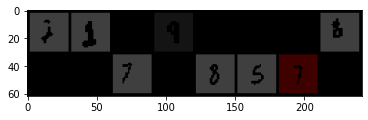

    7     1     3     9     3     0     8     8     0     5     7     3     8     5     7     5


In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].cpu().numpy() for j in range(16)))

# MODEL

Homogeneous Training Capsules
Inspired from the paper-'Homogeneous Vector Capsules Enable Adaptive Gradient Descent in Convolutional Neural Networks' , for more details please go through the summary.pdf

In [ ]:
class conv(nn.Module):
  def __init__(self, in_fea,out_fea):
    super().__init__()
    self.layer=nn.Sequential(nn.Conv2d(in_fea,out_fea,3),nn.ReLU(),nn.Dropout(0.2),
                             nn.Conv2d(out_fea,out_fea,3),nn.ReLU(),nn.Dropout(0.2),
                             nn.Conv2d(out_fea,out_fea,3),nn.ReLU(),nn.Dropout(0.2))
  def forward(self,x):
    return self.layer(x)

class capsule(nn.Module):
    def __init__(self, in_fea,out_fea):
      super().__init__()
      self.in_fea=in_fea
      self.layer1=nn.Linear(in_fea,out_fea)
      self.layer2=nn.Sequential(nn.Dropout(0.2),nn.BatchNorm1d(out_fea),nn.ReLU())   
    def forward(self,x):
       x=x.view(-1,self.in_fea,x.shape[2]*x.shape[3])
       x=x.permute(0,2,1)
       x=self.layer1(x)
       x=torch.sum(x,dim=1)
       x=self.layer2(x)
       return x
class BMCNN(nn.Module):
    def __init__(self, in_fea,out_fea):
      super().__init__()
      self.block1=conv(in_fea,64)
      self.block2=conv(64,112)
      self.block3=conv(112,160)
      self.cap1=capsule(64,out_fea)
      self.cap2=capsule(112,out_fea)
      self.cap3=capsule(160,out_fea)
    def forward(self,x):
       x1=self.block1(x)
       x2=self.block2(x1)
       x3=self.block3(x2)
       x1=self.cap1(x1)
       x2=self.cap2(x2)
       x3=self.cap3(x3)
       x=x1+x2+x3
       return x 

      


# TRAINING UTILS

SAVE CHECKPOINT

In [ ]:
def save_checkpoint(model, save_folder, name, epoch, opt, time1,best_model=False):

    if best_model:
        save_path = "{}/{}/best_model.th".format(
            save_folder, name)
    else:
        save_path = "{}/{}/epoch_{}.th".format(save_folder,
                                               name, epoch)

    if not os.path.exists(save_folder + "/" + name):
        os.makedirs(save_folder + "/" + name)

    print("SAVE MODEL to", save_path)


    param_dict = {
        'epoch': epoch,
        'avg_time':time1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt.state_dict()}
        

    torch.save(param_dict, save_path)
    #writer.close()
    distutils.dir_util.copy_tree('/content/runs','/'.join(save_path.split('/')[:-1])+'/runs')

LOAD CHECKPOINT

In [ ]:
def load_checkpoint(model, save_folder, model_name,epoch,opt,device ,best_model=False):
      if best_model:
        load_path = "{}/model_{}/best_model.th".format(save_folder, model_name)
      else:
        load_path = "{}/{}/epoch_{}.th".format(save_folder,
                                                model_name, epoch)

      checkpoint = torch.load(load_path,map_location=device)

      epoch = checkpoint['epoch']
      time1=checkpoint['avg_time']
      
      model =model # code for model init
      model.load_state_dict(checkpoint['model_state_dict'])
      model=model.to(device)

      opt =opt #code for opt init
      opt.load_state_dict(checkpoint['optimizer_state_dict'])
      #opt.param_groups[0]['lr'] = checkpoint['optimizer_params']['lr']
      distutils.dir_util.copy_tree('/'.join(load_path.split('/')[:-1])+'/runs','/content/runs')
      return model, opt, epoch, time1 


WEIGHT INITIALISATION

In [ ]:
from torch.nn import init
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

ACCURACY FUNCTION

In [ ]:
def accuracy_fn(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(1/ batch_size))
    return res

Average Meter

refernce-https://github.com/pytorch/tnt/blob/master/torchnet/meter/meter.py

In [ ]:
class Meter(object):
    '''Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    '''

    def reset(self):
        '''Resets the meter to default settings.'''
        pass

    def add(self, value):
        '''Log a new value to the meter
        Args:
            value: Next restult to include.
        '''
        pass

    def value(self):
        '''Get the value of the meter in the current state.'''
        pass



import math

import numpy as np


class AverageValueMeter(Meter):
    def __init__(self,std_sh=False):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0
        self.std_sh=std_sh
    def add(self, value, n=1):
        self.val = value
        self.sum += value * n
        if n <= 0:
            raise ValueError("Cannot use a non-positive weight for the running stat.")
        elif self.n == 0:
            self.mean = 0.0 + value  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + n * (value - self.mean_old) / float(self.n + n)
            self.m_s += n * (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n + n - 1.0))
        self.var = self.std ** 2

        self.n += n

    def value(self):
      if self.std_sh:
        return self.mean,self.std
      else:  
        return self.mean
    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan






class SumMeter(Meter):
    def __init__(self):
        super(SumMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value * n
        self.n += n

    def value(self):
        return self.sum

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.val = 0.0
        

Time calculation

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Convergence Calculation

In [ ]:
import sys
class Convergence(object):
   def __init__(self):
     self.cn_loss=sys.maxsize
     self.cnt=1
     self.meter=AverageValueMeter(True)
     self.meter.add(self.cn_loss)
     self.time=0
     self.epoch=0
   def calc(self,cn_loss,time,epoch):
     if cn_loss>=self.cn_loss:
       self.meter.add(cn_loss)
       self.cnt+=1
      
     else:
       self.meter.reset()
       self.meter.add(cn_loss)
       self.time=time
       self.epoch=epoch
       self.cnt=1
       self.cn_loss=cn_loss

# Train

Training function

In [ ]:
def train(model,train_loader,criterion,optimizer,scheduler,meters,epoch,pr_br,ch=3):
    model.train()
    meters['train_loss'].reset()

    for batch_idx, (data,label) in enumerate(train_loader):
        if ch==1:
          data = data.expand(-1, 3, -1, -1)
        data = data.to(device)
        label=label.to(device)
        optimizer.zero_grad()
        output= model(data)
        loss = criterion(output,label)
        loss.backward()
        meters['train_loss'].add(loss.item())
        optimizer.step()
        writer.add_scalar("Train_Loss/iter", meters['train_loss'].value(),epoch*len(train_loader)+batch_idx )
        if batch_idx %pr_br == 0:        
            print(' Epoch: {} Iter: {} Average train loss: {:.4f}'.format(
                epoch,batch_idx, meters['train_loss'].value()))
    writer.add_scalar("Train_Loss/epoch", meters['train_loss'].value(),epoch)
   # scheduler.step()

Evaluation function

In [ ]:
def mod_eval(model,test_loader,criterion,meters,epoch,pr_br,ch=3):
    model.eval()
    meters['val_loss'].reset()
    meters['val_a1'].reset()
    meters['val_a3'].reset()
    meters['val_a5'].reset()
    for batch_idx, (data,label) in enumerate(test_loader):
        if ch==1:
          data = data.expand(-1, 3, -1, -1)
        data = data.to(device)
        label=label.to(device)
        optimizer.zero_grad()
        output= model(data)
        loss = criterion(output,label)
        meters['val_loss'].add(loss.item())
        r=accuracy_fn(output.data,label.data,(1,3,5))
        meters['val_a1'].add(r[0].item())
        meters['val_a3'].add(r[1].item())
        meters['val_a5'].add(r[2].item())
        writer.add_scalar("Val_Loss/iter", meters['val_loss'].value(),epoch*len(test_loader)+batch_idx )
        writer.add_scalar("accuracy_1/iter", meters['val_a1'].value(), epoch*len(test_loader)+batch_idx)
        writer.add_scalar("accuracy_3/iter", meters['val_a3'].value(),epoch*len(test_loader)+batch_idx)
        writer.add_scalar("accuracy_5/iter", meters['val_a5'].value(), epoch*len(test_loader)+batch_idx)
      
        if batch_idx % pr_br == 0:        
            print(' Epoch: {} Iter: {} Average val loss: {:.4f} Acc1: {:.2f} Acc3: {:.2f} Acc5: {:.2f}'.format(
                epoch,batch_idx, meters['val_loss'].value(),meters['val_a1'].value(),meters['val_a3'].value(),meters['val_a5'].value()))
    writer.add_scalar("Val_Loss/epoch", meters['val_loss'].value(),epoch )
    writer.add_scalar("accuracy_1/epoch", meters['val_a1'].value(), epoch)
    writer.flush()

Main

In [ ]:
import time
from torch.utils.tensorboard import SummaryWriter
def run(model,criterion,optimizer,scheduler,load_dir,load_model,load_epch=0,N_EPOCHS=20,save_fq=5,load=False,ch=3):
  lst_epch=0
  cnt=1
 
  writer = SummaryWriter()
  if load==True:
    model,optimizer,lst_epch,meters['time'].val=load_checkpoint(model,load_dir,load_model,load_epch,optimizer,device)
    #scheduler=
    lst_epch+=1
  for epoch in range(lst_epch,lst_epch+N_EPOCHS):
      
      start_time = time.time()
      
      train(model,train_loader,criterion,optimizer, scheduler,meters,epoch,1000,ch)

     
      end_time = time.time()
      meters['time'].add(end_time-start_time)
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
         

      mod_eval(model,test_loader,criterion,meters,epoch,1000,ch)

      con.calc(meters['val_loss'].value(),meters['time'].value(),epoch)


      print('\n')
      print('====> After epoch {} '.format(epoch))
      print(f'====>Epoch Time: {epoch_mins}m {epoch_secs}s')
      print('====>Average train loss: {:.4f} '.format(
                 meters['train_loss'].value()))
      print('====> Average val loss: {:.4f} Acc1: {:.2f} Acc3: {:.2f} Acc5: {:.2f}'.format(
                 meters['val_loss'].value(),meters['val_a1'].value(),meters['val_a3'].value(),meters['val_a5'].value()))
      print('\n')
      
      if con.cnt>=5:
        save_checkpoint(model,load_dir,load_model,epoch,optimizer, meters['time'].value())
        break

      scheduler.step(meters['val_loss'].value())
      if(cnt%save_fq==0):
        save_checkpoint(model,load_dir,load_model,epoch,optimizer, meters['time'].value())
      cnt+=1  

to run without a test_set

In [ ]:
import time
from torch.utils.tensorboard import SummaryWriter
def run_train(model,criterion,optimizer,scheduler,load_dir,load_model,load_epch=0,N_EPOCHS=20,save_fq=5,load=False):
  lst_epch=0
  cnt=1
 
  writer = SummaryWriter()
  if load==True:
    model,optimizer,lst_epch,meters['time'].val=load_checkpoint(model,load_dir,load_model,load_epch,optimizer,device)
    #scheduler=
    lst_epch+=1
  for epoch in range(lst_epch,lst_epch+N_EPOCHS):
      
      start_time = time.time()
      
      train(model,train_loader,criterion,optimizer, scheduler,meters,epoch,100)

     
      end_time = time.time()
      meters['time'].add(end_time-start_time)
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      

      con.calc(meters['train_loss'].value(),meters['time'].value(),epoch)
     
     
     
      print('\n')
      print('====> After epoch {} '.format(epoch))
      print(f'====>Epoch Time: {epoch_mins}m {epoch_secs}s')
      print('====>Average train loss: {:.4f} '.format(
                 meters['train_loss'].value()))
      print('\n')
      
      if con.cnt>=5:
        save_checkpoint(model,load_dir,load_model,epoch,optimizer, meters['time'].value())
        break


      scheduler.step(meters['train_loss'].value())
      if(cnt%save_fq==0):
        save_checkpoint(model,load_dir,load_model,epoch,optimizer, meters['time'].value())
      cnt+=1  

Model, Loss and Other Auxilary Training Initilisations

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
model=BMCNN(3,10)
model=model.to(device)

init_weights(model,'kaiming')
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
con=Convergence()
meters={'val_loss':AverageValueMeter(),'val_a1':AverageValueMeter(),'val_a3':AverageValueMeter(),'val_a5':AverageValueMeter(),'train_loss':AverageValueMeter(),'time':SumMeter()}

initialize network with kaiming


# Run and Evalution for all the 62 classes

Run

In [ ]:
run_train(model,criterion,optimizer,scheduler,'/content/drive/MyDrive/Model_files','task2/BMCNN_part1',0,70,10,False)

 Epoch: 0 Iter: 0 Average train loss: 4.2706
 Epoch: 0 Iter: 100 Average train loss: 4.5716


====> After epoch 0 
====>Epoch Time: 0m 34s
====>Average train loss: 4.5318 


 Epoch: 1 Iter: 0 Average train loss: 4.4155
 Epoch: 1 Iter: 100 Average train loss: 4.3727


====> After epoch 1 
====>Epoch Time: 0m 34s
====>Average train loss: 4.3441 


 Epoch: 2 Iter: 0 Average train loss: 4.5803
 Epoch: 2 Iter: 100 Average train loss: 4.2247


====> After epoch 2 
====>Epoch Time: 0m 33s
====>Average train loss: 4.1836 


 Epoch: 3 Iter: 0 Average train loss: 4.2621
 Epoch: 3 Iter: 100 Average train loss: 4.0549


====> After epoch 3 
====>Epoch Time: 0m 34s
====>Average train loss: 4.0082 


 Epoch: 4 Iter: 0 Average train loss: 3.9282
 Epoch: 4 Iter: 100 Average train loss: 3.8463


====> After epoch 4 
====>Epoch Time: 0m 34s
====>Average train loss: 3.8120 


 Epoch: 5 Iter: 0 Average train loss: 4.0263
 Epoch: 5 Iter: 100 Average train loss: 3.6955


====> After epoch 5 
====>Epoch Time

Convergence Metrics

In [ ]:
print('====> After epoch {} '.format(con.epoch))
print('====>conv Time: {}'.format(con.time))
#print('====>conv Time: {}'.format(con.time))
print('====>Average train loss: {:.4f} +-{:.4f}'.format(
                 con.meter.value()[0],con.meter.value()[1]))

====> After epoch 55 
====>conv Time: 1907.9600670337677
====>Average train loss: 1.2845 +-0.0171


Train Accuracy

In [ ]:

print('Train_accuracy:'.format(acc_meter.value())

Train_accuracy: 0.8620967741935484


In [ ]:
def conf(model,test_loader,n_class):
  nb_classes = n_class
  model.to(device)
  model.eval()
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(test_loader):
          inputs = inputs.to(device)
          inputs=inputs.expand(-1, 3, -1, -1)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix

Confusion Matrix

Confusion matrix, without normalization
[[35  0  0 ...  0  0  0]
 [ 0 21  0 ...  0  0  0]
 [ 0  0 31 ...  0  0  0]
 ...
 [ 0  0  0 ... 29  4  0]
 [ 0  0  0 ...  0 36  0]
 [ 0  0  0 ...  0  0 39]]


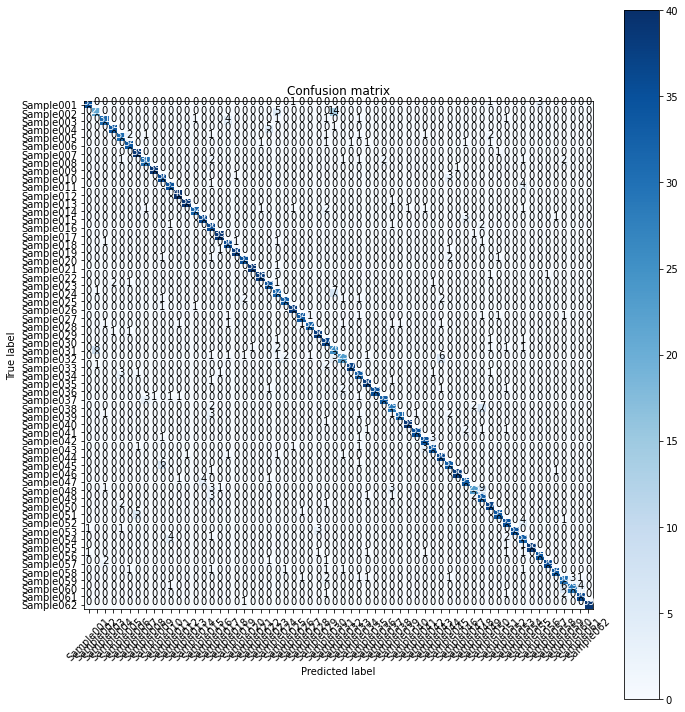

In [ ]:
train_labels,train_preds = get_all_preds(model, train_loader)
cm = confusion_matrix(train_labels, train_preds.argmax(dim=1))
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, lst1)

# Run and Evalution for (0-9) classes

Train_dataset(0-9)

In [ ]:
batch_size = 16
dataset=Custom_dataset(root='/content/train',img_type='png',mnist=True,transforms=seq)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Convergence Metrics

In [ ]:
run_train(model,criterion,optimizer,scheduler,'/content/drive/MyDrive/Model_files','task2/BMCNN_(0-9)_part2',0,100,10,False)

 Epoch: 0 Iter: 0 Average train loss: 3.0626


====> After epoch 0 
====>Epoch Time: 0m 5s
====>Average train loss: 2.6124 


 Epoch: 1 Iter: 0 Average train loss: 2.2847


====> After epoch 1 
====>Epoch Time: 0m 5s
====>Average train loss: 2.5068 


 Epoch: 2 Iter: 0 Average train loss: 2.2013


====> After epoch 2 
====>Epoch Time: 0m 5s
====>Average train loss: 2.5091 


 Epoch: 3 Iter: 0 Average train loss: 2.5242


====> After epoch 3 
====>Epoch Time: 0m 5s
====>Average train loss: 2.4903 


 Epoch: 4 Iter: 0 Average train loss: 2.3181


====> After epoch 4 
====>Epoch Time: 0m 5s
====>Average train loss: 2.3724 


 Epoch: 5 Iter: 0 Average train loss: 1.9034


====> After epoch 5 
====>Epoch Time: 0m 5s
====>Average train loss: 2.3534 


 Epoch: 6 Iter: 0 Average train loss: 2.6350


====> After epoch 6 
====>Epoch Time: 0m 5s
====>Average train loss: 2.3031 


 Epoch: 7 Iter: 0 Average train loss: 2.5244


====> After epoch 7 
====>Epoch Time: 0m 5s
====>Average train loss: 2.

Convergence Metrics

In [ ]:
print('====> After epoch {} '.format(con.epoch))
print('====>conv Time: {}'.format(con.time))
#print('====>conv Time: {}'.format(con.time))
print('====>Average train loss: {:.4f} +-{:.4f}'.format(
                 con.meter.value()[0],con.meter.value()[1]))

====> After epoch 40 
====>conv Time: 223.8778576850891
====>Average train loss: 1.0198 +-0.0440


Train Accuracy

In [ ]:
acc_meter=AverageValueMeter()
model.eval()
for batch_idx, (data,label) in enumerate(train_loader):
    data = data.to(device)
    label=label.to(device)
    data = data.expand(-1, 3, -1, -1)
    output= model(data)
    
   
    r=accuracy_fn(output.data,label.data,(1,3,5))
    acc_meter.add(r[0].item())
print('Train_accuracy:{}'.format(acc_meter.value()))

Train_accuracy:0.84


Confusion Matrix

In [ ]:
def conf(model,test_loader,n_class):
  nb_classes = n_class
  model.to(device)
  model.eval()
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(test_loader):
          inputs = inputs.to(device)
          inputs=inputs.expand(-1, 3, -1, -1)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix

Confusion matrix, without normalization
[[26  2  1  2  2  0  7  0  0  0]
 [ 0 36  1  1  1  0  0  1  0  0]
 [ 0  0 37  0  1  0  1  1  0  0]
 [ 0  2  0 30  1  0  3  0  1  3]
 [ 0  0  0  0 35  0  2  0  0  3]
 [ 0  0  0  2  1 34  2  0  0  1]
 [ 0  0  0  0  1  0 38  0  1  0]
 [ 0  0  0  0  3  0  0 33  0  4]
 [ 0  0  0  0  1  0  2  0 37  0]
 [ 0  2  0  0  2  0  0  0  1 35]]


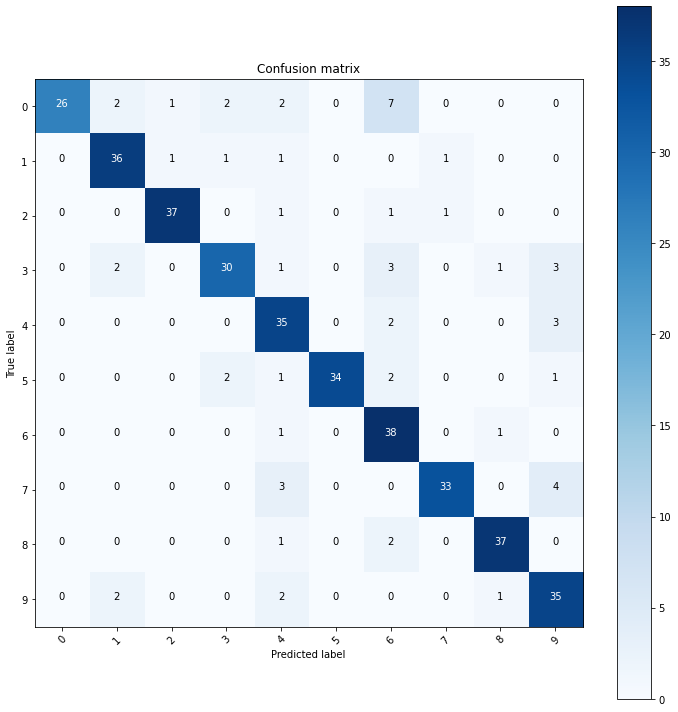

In [ ]:
cm=conf(model,train_loader,10)
cm=cm.cpu().numpy().astype('uint64')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, lst1)

# TensorBoard Visualisation

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs